# Fine Tuning YOLO on a Custom Dataset
This notebook creates a custom dataset of randomly sized and colored circles and triangles along with an annotation file formatted for YOLO. It then uses that data to perform fine tuning on one of the pre-trained models and displays the results.

First let's import all the libraries we'll need for the notebook.

In [1]:
import cv2
import numpy as np
import os
import shutil 
from IPython.display import Image, display, Code
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
%matplotlib inline

WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/home/brian/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Create the Dataset
Create a dataset of randomly sized and colored circles and triangles.

In [2]:
# Specify a root location for the dataset
DATA_DIR = "./datasets"

# Specify the hight and width of the images in the dataset (640 is the default YOLO size)
(IMG_WIDTH, IMG_HEIGHT) = (640, 640)

In [3]:
def delete_dirs(dirs=[]):
    """Deletes a list of directories

    Args:
        dirs (list, optional): The directories to delete. Defaults to [].
    """

    for dir in dirs:
        if os.path.exists(dir):
            shutil.rmtree(dir) 

# Delete folders generated during previous training cycles
delete_dirs(['runs/detect', f'{DATA_DIR}/test', f'{DATA_DIR}/train', f'{DATA_DIR}/val'])

In [4]:
def get_yolo_annotations(x1, y1, x2, y2, image_width, image_height):
    """Convert bounding box annotations to YOLO annotations that are resilient to image resizing.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image

    Returns:
        center_x (float): The distance of the bounding box's center from the left side of the image. Expressed in the range of 0.0 to 1.0.
        center_y (float): The distance of the bounding box's center from the top of the image. Expressed in the range of 0.0 to 1.0.
        width (float):    The percentage of the image's width that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
        height (float):   The percentage of the image's height that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
    """

    center_x = (x2+x1)/2/image_width
    center_y = (y2+y1)/2/image_height
    width    = (x2-x1)/image_width
    height   = (y2-y1)/image_height
    
    return center_x, center_y, width, height

In [5]:
def write_yolo_annotations(x1, y1, x2, y2, image_width, image_height, class_id, label_file):
    """Convert the bounding box annotations to YOLO format and write to a file.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image
        class_id (int): A unique integer associated with the class
        label_file (string): The file location to write the annotations
    """
    
    # Get YOLO annotations
    center_x, center_y, width, height = get_yolo_annotations(x1, y1, x2, y2, image_width, image_height)

    # Make sure values are reasonable
    if center_x > 0 and center_y > 0 and width > 0 and height > 0 and \
       center_x <= 1 and center_y <= 1 and width <= 1 and height <= 1:
        
        # Write the annotations
        f = open(label_file, 'a')
        f.write('{} {} {} {} {}\n'.format(class_id, center_x, center_y, width, height))
        f.close()
    else:
        print(f"At least a portion of the class is outside the image boundary ({center_x}, {center_y}, {width}, {height})")

In [6]:
def draw_random_circle(img):
    """Draws a randomly sized and colored circle on an image

    Args:
        img (array): The image to modify

    Returns:
        center_x (int): The x coordinate for the center of the circle
        center_y (int): The y coordinate for the center of the circle
        radius (int): The radius of the circle
    """
    
    radius   = np.random.randint(10, 100)
    center_x = np.random.randint(radius, IMG_WIDTH-radius)
    center_y = np.random.randint(radius, IMG_HEIGHT-radius)
    color    = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.circle(img, (center_x, center_y), radius, color, -1)

    return center_x, center_y, radius

In [7]:
def draw_random_triangle(img):
    """Draws a randomly sized and colored triangle on an image

    Args:
        img (array): The image to modify

    Returns:
        lhs (int): The x coordinate for the center of the circle
        rhs (int): The y coordinate for the center of the circle
        top (int): The radius of the circle
        bottom (int) :
    """

    # get a random point in the image at least 100 pixels from the border
    pt1 = (np.random.randint(100, IMG_WIDTH-100), np.random.randint(100, IMG_HEIGHT-100))
    # get a second point 50 to 100 pixels from the first point 
    pt2 = (pt1[0]+np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))
    # get a third point 50 to 100 pixels from the first point
    pt3 = (pt1[0]-np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))

    triangle = np.array( [pt1, pt2, pt3] )

    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.drawContours(img, [triangle], 0, color, -1)

    x_vals = [x[0] for x in triangle]
    y_vals = [x[1] for x in triangle]

    lhs = np.min(x_vals)
    rhs = np.max(x_vals)
    top = np.min(y_vals)
    bottom = np.max(y_vals)

    return lhs, rhs, top, bottom

In [8]:
CIRCLE_CLASS_ID   = 0
TRIANGLE_CLASS_ID = 1

def create_data(dir, num_images):
    """Populates a directory with a dataset

    Args:
        dir (string): The root directory of the dataset
        num_images (ing): The number of images in the dataset
    """
    
    img_dir   = os.path.join(DATA_DIR, dir, "images")
    label_dir = os.path.join(DATA_DIR, dir, "labels")
    os.makedirs(img_dir,   exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in range(num_images):
        img = np.random.randint(0, 255, (IMG_HEIGHT, IMG_WIDTH, 3), "uint8")
        img_file   = "{}/{}.jpg".format(img_dir,   i)
        label_file = "{}/{}.txt".format(label_dir, i)

        center_x, center_y, radius = draw_random_circle(img)
        write_yolo_annotations(center_x-radius, center_y-radius, center_x+radius, center_y+radius, IMG_WIDTH, IMG_HEIGHT, CIRCLE_CLASS_ID, label_file)

        x_min, x_max, y_min, y_max = draw_random_triangle(img)
        write_yolo_annotations(x_min, y_min, x_max, y_max, IMG_WIDTH, IMG_HEIGHT, TRIANGLE_CLASS_ID, label_file)

        cv2.imwrite(img_file, img)

Let's use these methods we just created to make our dataset.

In [9]:
create_data("train", 150)
create_data("test" ,  25)
create_data("val"  ,   9)

Let's print out one of our validation images and annotations to make sure everything looks good.

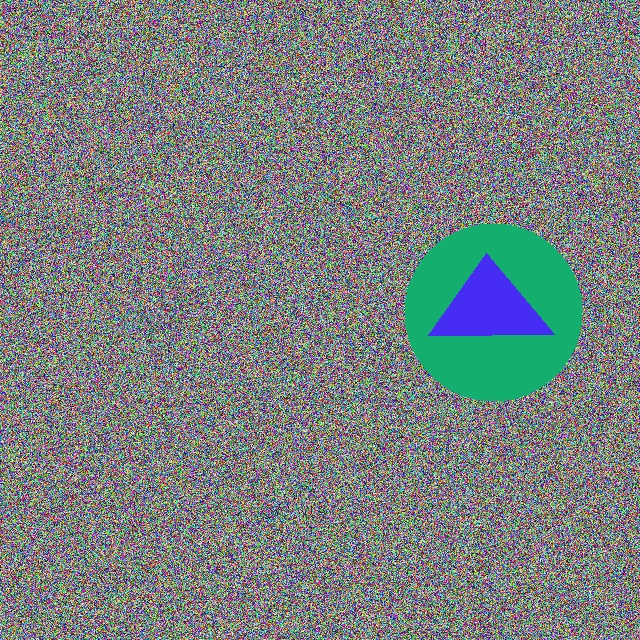

0 0.7703125 0.4875 0.278125 0.278125
1 0.7671875 0.459375 0.196875 0.128125

In [10]:
val_images_dir = 'datasets/val/images/'
val_anno_dir   = 'datasets/val/labels/'

images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
labels = [f"{val_anno_dir}{label}" for label in os.listdir(val_anno_dir)]
images.sort()
labels.sort()

# Display the image
display(Image(images[0]))

# Display the annotations
Code(filename=labels[0], language='console')

# Train the Model

In [11]:
def create_config_file(config_file):
    """Creates and writes a YOLO config file necessary for training. 

    Args:
        config_file (str): The filename.'.
    """

    if not os.path.exists(config_file):
        f = open(config_file, "x")
        f.write('''\
# Train and test folders
train: 'datasets/train'
val: 'datasets/test'

# Number of classes
nc: 2
names: ['circle', 'triangle']''')
        f.close()

config_file = 'object_v12.yaml'
create_config_file(config_file)

In [12]:
# Initialize the YOLO model and print out the supported classes
YOLO_MODEL = 'yolo12n'
model = YOLO('{}.pt'.format(YOLO_MODEL))

print(model.names.values())

dict_values(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])


In [13]:
# Start the training
_ = model.train(
    data = config_file,
    imgsz = 640,
    epochs = 50,
    batch = 32,
    #device='cpu',
    name = YOLO_MODEL
)

Ultralytics 8.3.183 🚀 Python-3.12.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11163MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=object_v12.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2155.1±215.1 MB/s, size: 444.9 KB)


train: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/train/labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 972.72it/s]

train: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2229.4±1336.9 MB/s, size: 444.1 KB)


val: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/test/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 2120.43it/s]

val: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/test/labels.cache


Plotting labels to runs/detect/yolo12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo12n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.13G     0.8908      3.581      1.086         60        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         25         50    0.00373       0.56     0.0254      0.024

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50      6.17G     0.9727       3.61      1.146         73        640: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         25         50    0.00657       0.98      0.261      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.18G     0.6931      2.769     0.9142         76        640: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         25         50     0.0064       0.96      0.665      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.18G     0.6966      1.799     0.9882         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         25         50    0.00909       0.96      0.843      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.18G     0.6413       1.23     0.9616         47        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         25         50     0.0102       0.94      0.839       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.18G     0.6085      1.035     0.9422         71        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         25         50    0.00824       0.84       0.65      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.18G     0.6007      1.029     0.9434         50        640: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         25         50    0.00171       0.26     0.0025    0.00136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.18G     0.6017     0.9906     0.9138         68        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         25         50   0.000287       0.02   0.000151   1.51e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.18G      0.613     0.9155     0.9456         72        640: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         25         50          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.18G     0.5986      0.938     0.9239         60        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         25         50    0.00325       0.44    0.00612    0.00177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.18G     0.5649     0.8492       0.94         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         25         50    0.00406       0.52    0.00604    0.00189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.19G     0.5321     0.8204     0.9118         84        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         25         50    0.00614       0.66      0.155      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.15G      0.523     0.7946     0.9026         56        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         25         50          1     0.0958      0.482      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.19G      0.512     0.7488     0.8823         83        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         25         50          1      0.228      0.704      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.18G     0.5188     0.7861     0.8997         72        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         25         50          1      0.175      0.768      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.19G      0.488     0.7442     0.9105         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         25         50          1      0.174      0.747      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.18G     0.5216     0.7133     0.9055         68        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         25         50          1      0.252      0.819      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.19G     0.4994     0.6945     0.9126         59        640: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         25         50          1      0.493      0.853      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.18G     0.5252     0.6842     0.9179         65        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         25         50          1      0.649      0.967      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.19G     0.5075     0.6675     0.8999         74        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         25         50      0.989      0.796      0.989      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.18G     0.4897     0.6595     0.9042         73        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         25         50      0.981      0.809      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.19G     0.4862     0.6584     0.9062         56        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         25         50      0.975      0.875      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.18G     0.4675     0.6276     0.8855         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         25         50      0.986      0.984      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.19G     0.4532     0.5902     0.8856         70        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         25         50      0.964      0.971      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.18G     0.4637       0.61     0.9039         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         25         50       0.93      0.993      0.977      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.19G     0.4436     0.5854       0.89         66        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         25         50      0.984          1      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.18G     0.4513     0.5728      0.886         70        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         25         50      0.976          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.19G     0.4709     0.5706     0.8943         64        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         25         50      0.979          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.18G     0.4783     0.5661     0.8892         69        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         25         50      0.987          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.19G     0.4108      0.523     0.8766         78        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         25         50      0.977          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.18G     0.4203     0.5335     0.8705         83        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25         50      0.981          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.19G     0.4229     0.5232     0.8748         46        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         25         50       0.99          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.18G     0.4341      0.526     0.8871         69        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         25         50      0.989          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.19G     0.4053     0.4957      0.869         58        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         25         50       0.99          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.18G     0.3758      0.492      0.872         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         25         50      0.992          1      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.19G     0.3827     0.4765     0.8889         73        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         25         50      0.993          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.18G      0.382     0.4785     0.8786         53        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         25         50      0.994          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.19G     0.3459     0.4477     0.8601         64        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25         50      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.18G     0.3731     0.4529     0.8565         81        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         25         50      0.996          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.19G     0.3532     0.4532     0.8627         57        640: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         25         50      0.997          1      0.995      0.969


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.15G     0.2752     0.4389     0.8278         43        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         25         50      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.16G     0.2743     0.4419     0.8206         42        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25         50      0.995          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.15G     0.2739     0.4279     0.8225         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         25         50      0.995          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.16G     0.2577     0.4119     0.8024         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         25         50      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.15G     0.2523     0.4037     0.8221         42        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25         50      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.16G     0.2442     0.4004     0.8097         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         25         50      0.996          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.15G      0.241     0.4006     0.8102         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         25         50      0.996          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.16G     0.2324     0.3866     0.8125         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         25         50      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.15G     0.2256     0.3854      0.818         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25         50      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.16G     0.2194     0.3674     0.8102         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         25         50      0.997          1      0.995      0.991



50 epochs completed in 0.042 hours.
Optimizer stripped from runs/detect/yolo12n/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo12n/weights/best.pt, 5.5MB

Validating runs/detect/yolo12n/weights/best.pt...
Ultralytics 8.3.183 🚀 Python-3.12.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11163MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


                   all         25         50      0.997          1      0.995      0.991
                circle         25         25      0.998          1      0.995      0.987
              triangle         25         25      0.995          1      0.995      0.995
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/yolo12n


In [14]:
# Display the classes the model supports now
print(model.names)

{0: 'circle', 1: 'triangle'}


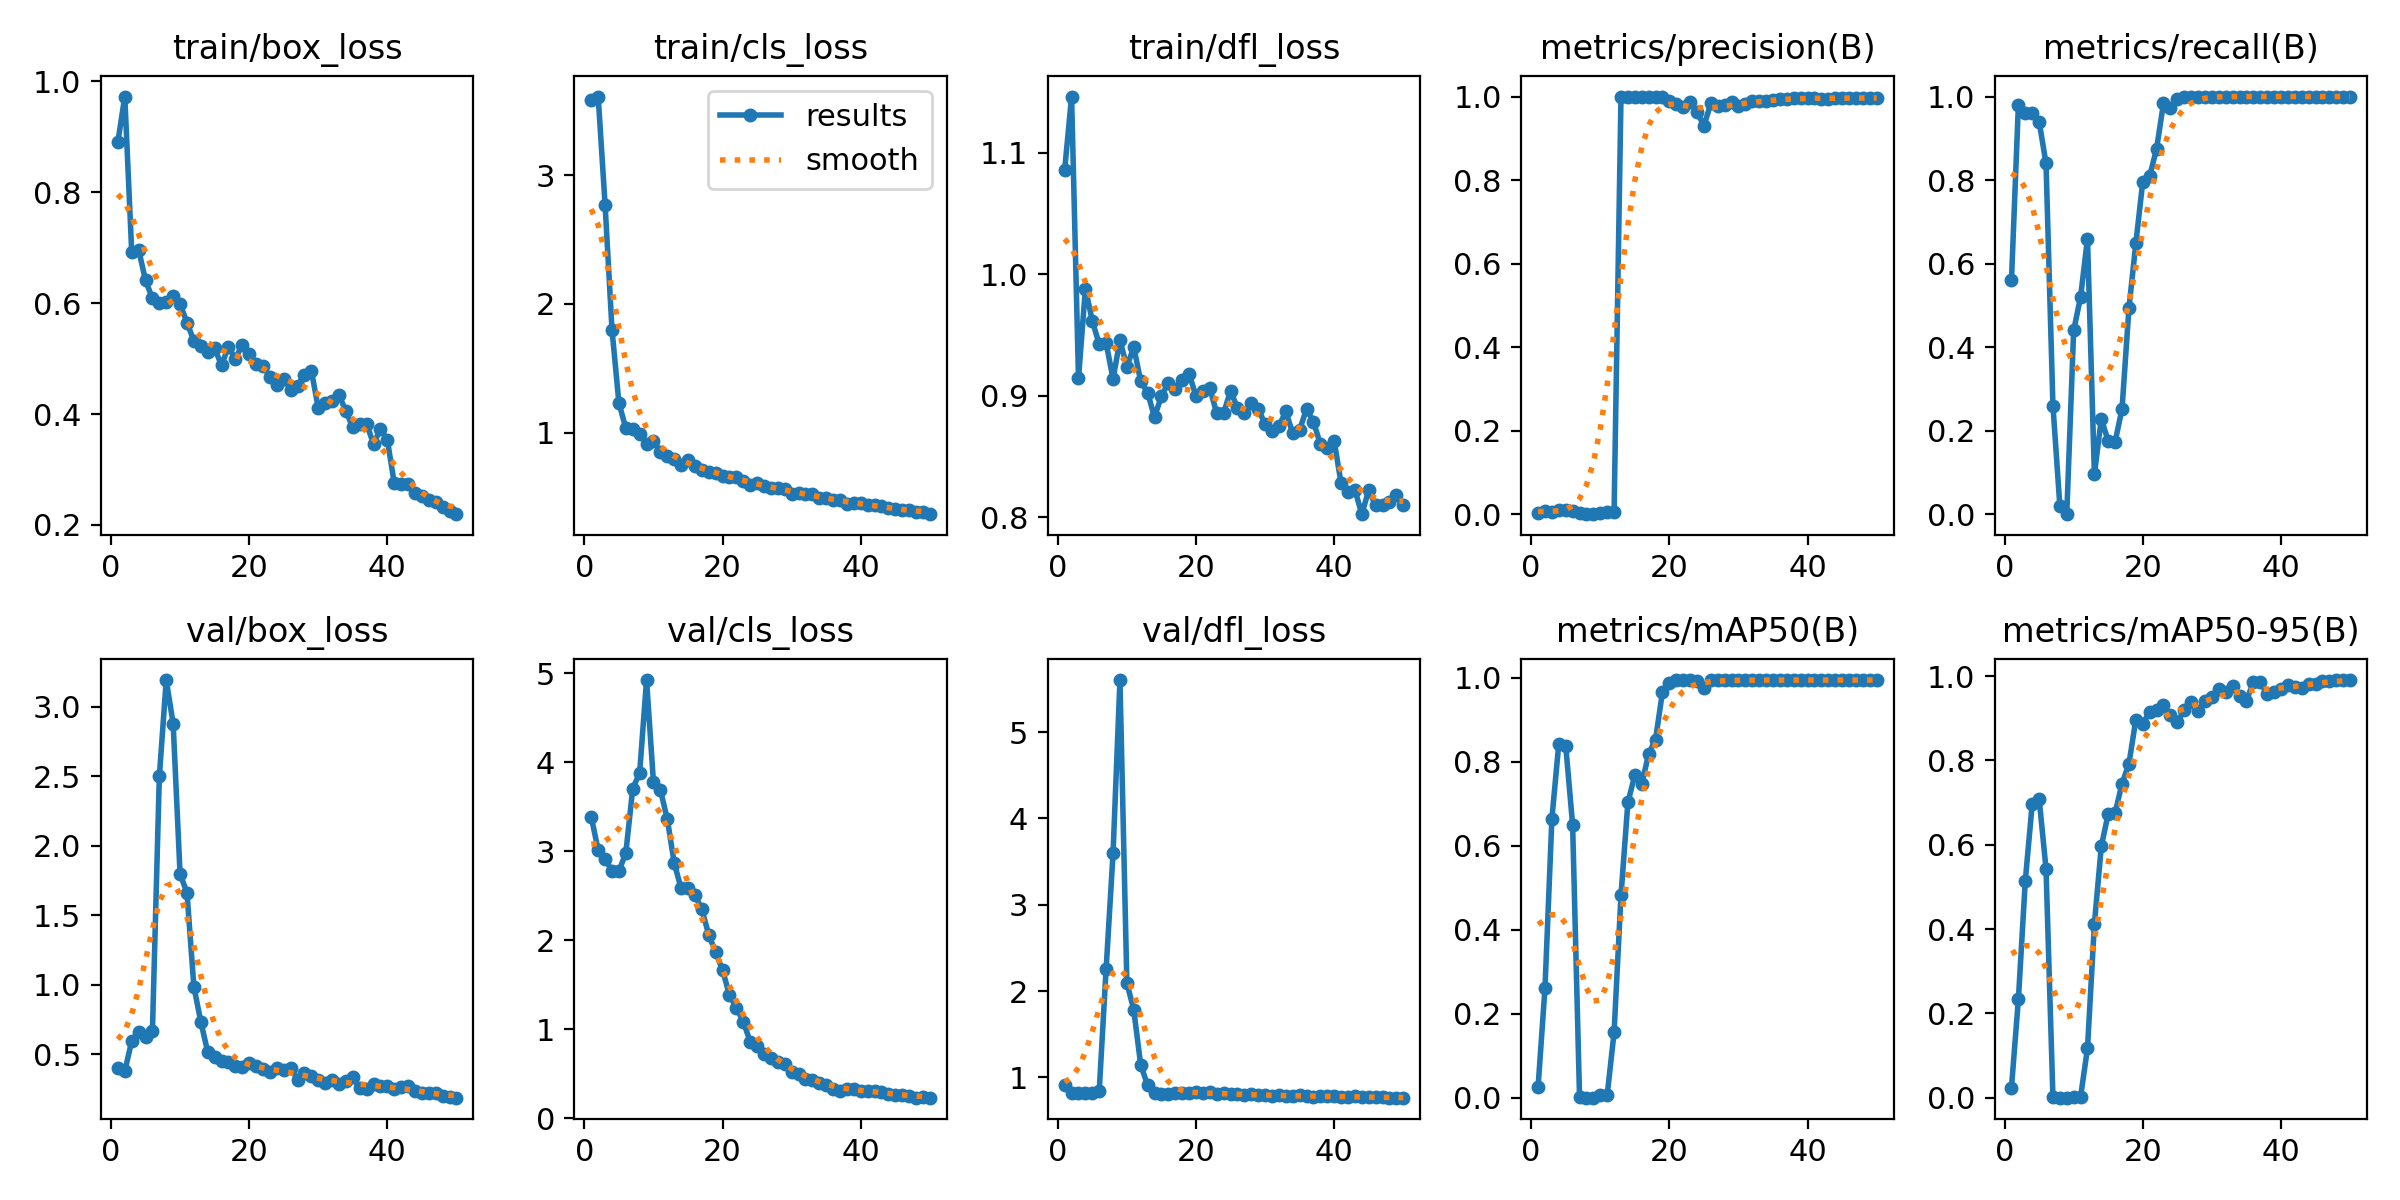

In [15]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/results.png'))

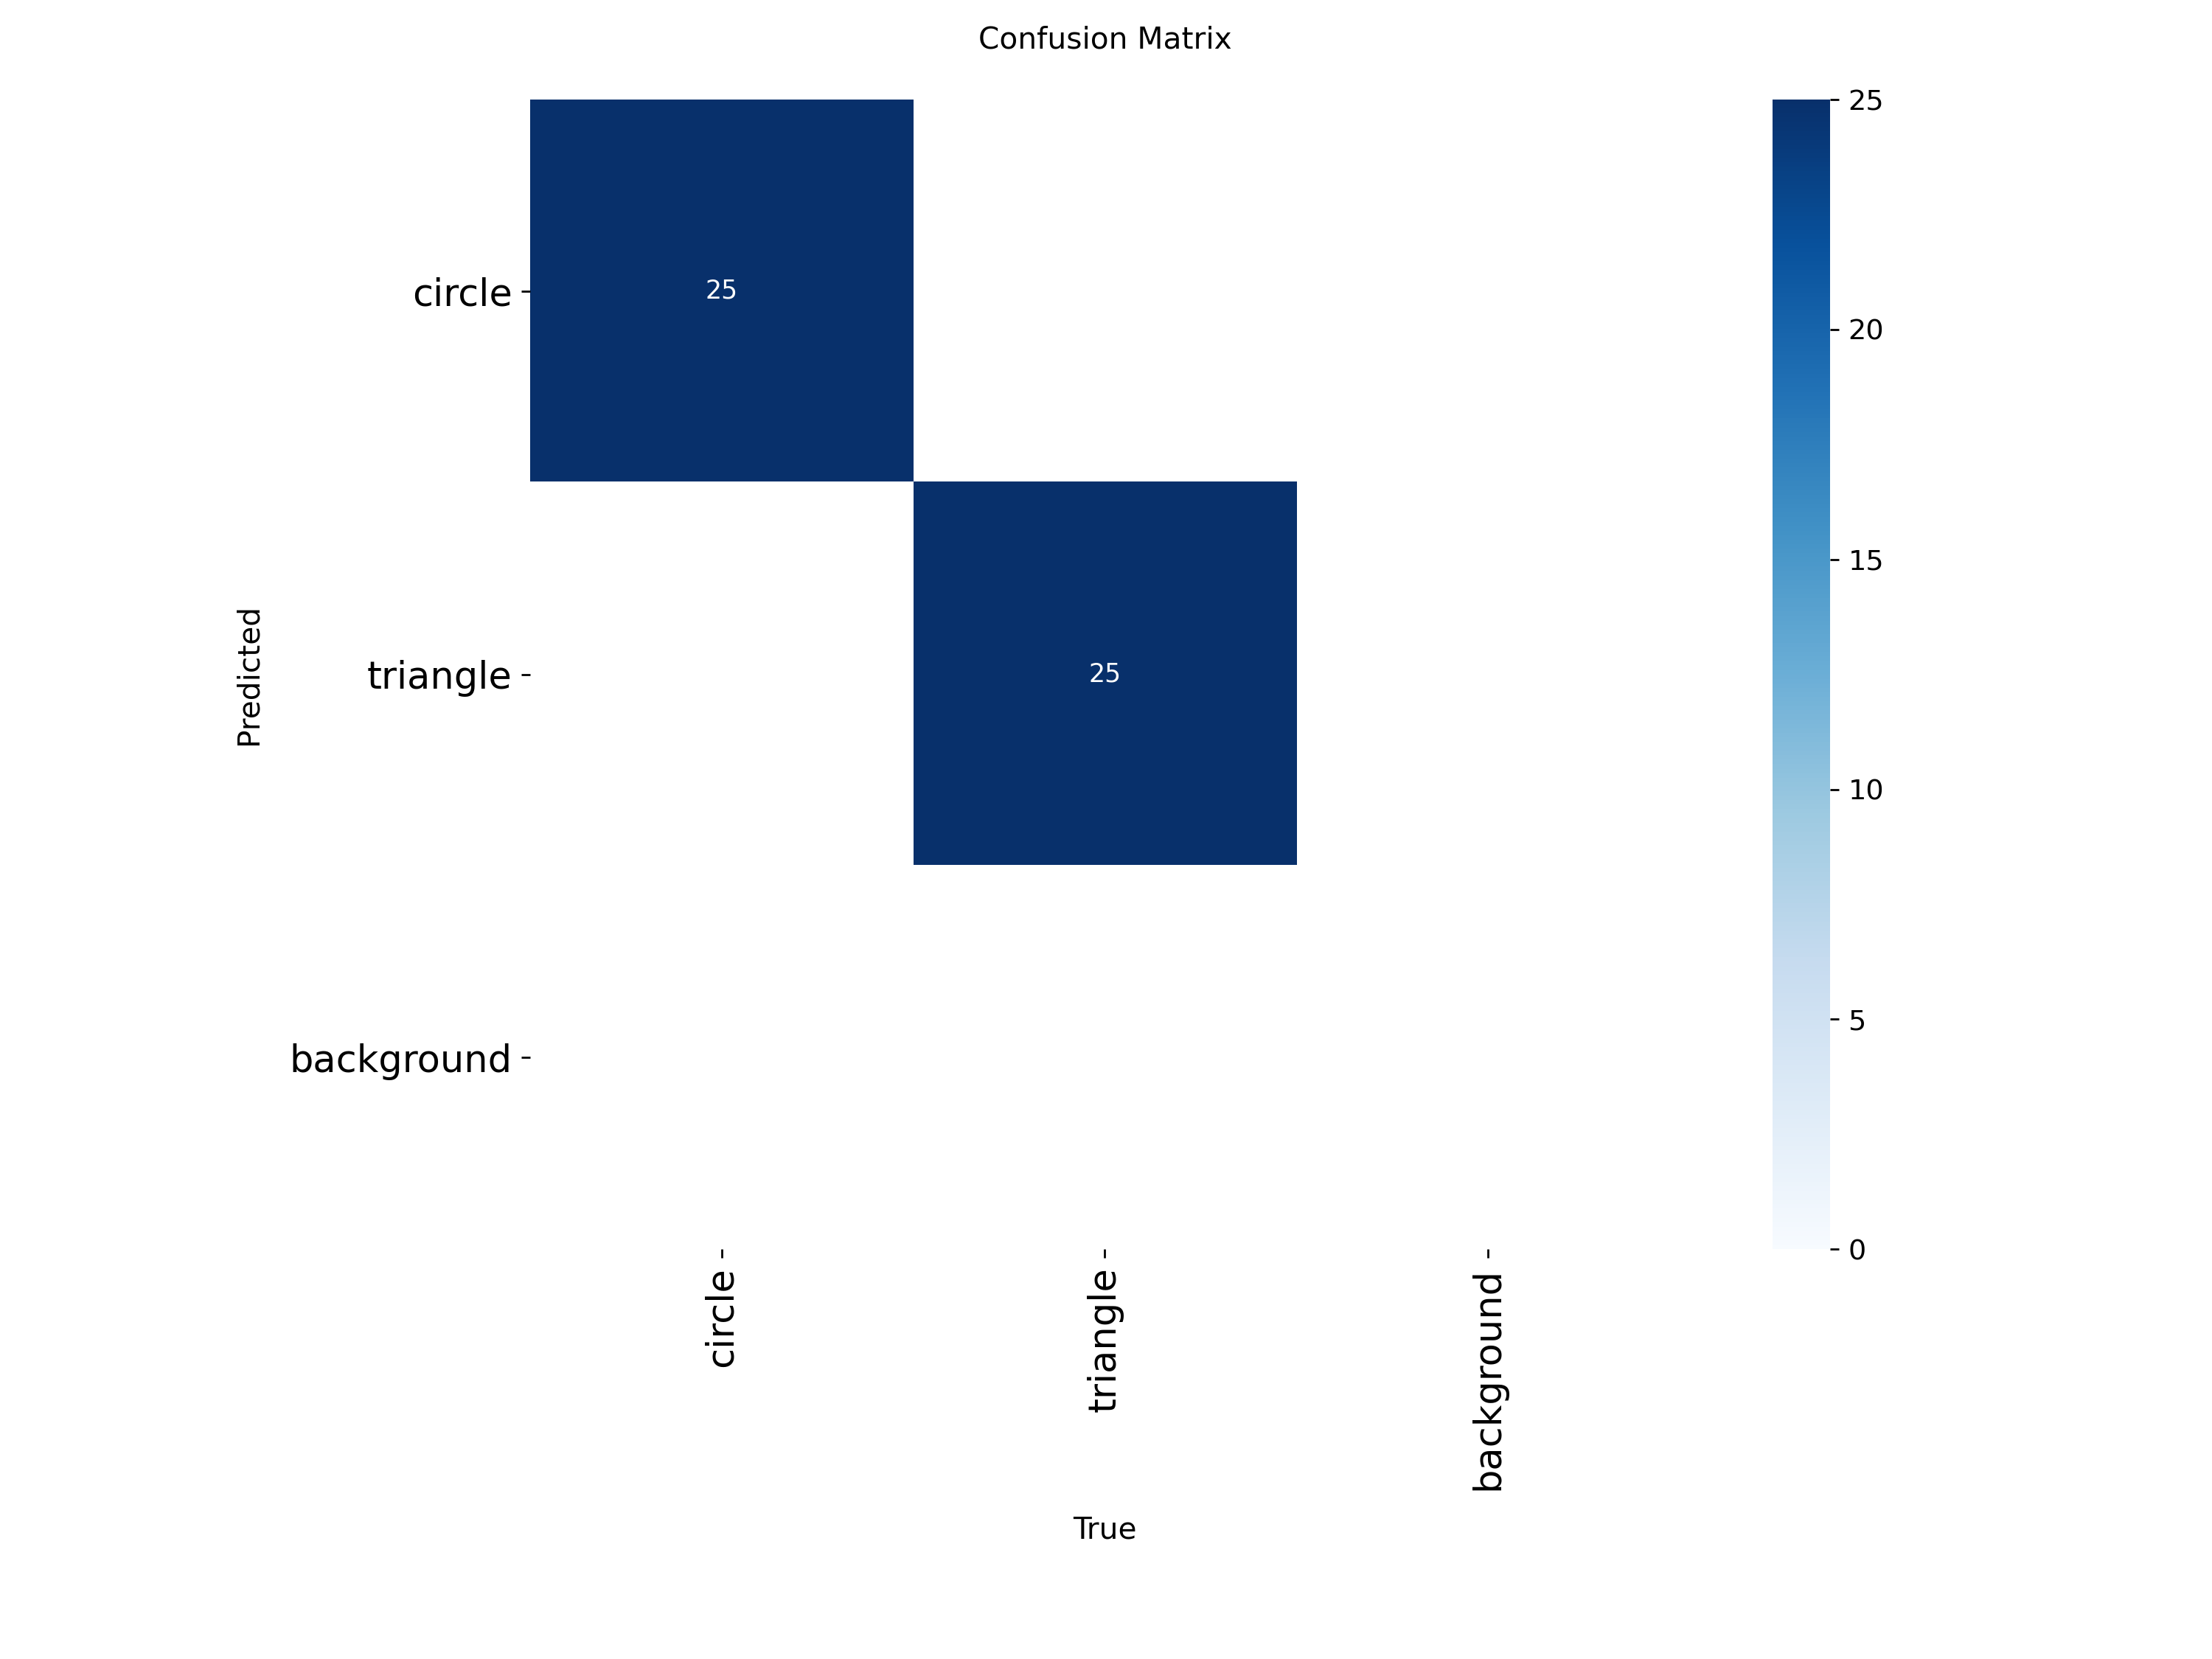

In [16]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/confusion_matrix.png', width=1000, height=1000))

## Run YOLO

Let's annotate some of the model's output to see how it does.

In [17]:
# Load the best model
best_yolo_model = f'runs/detect/{YOLO_MODEL}/weights/best.pt'
model = YOLO(best_yolo_model)

# Load the paths to the validation images
val_images_dir = f'{DATA_DIR}/val/images/'
test_images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
batch_size = 64

# Create annotators for bounding box and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_LEFT)

images = []

for i in range(0, len(test_images), batch_size):
    results = model.predict(test_images[i:i + batch_size])
    for result in results:
        detections = sv.Detections.from_ultralytics(result)
        img = cv2.imread(result.path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Annotate
        annotated_image = box_annotator.annotate(scene=img, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

        images.append(annotated_image)


0: 640x640 1 circle, 1 triangle, 4.2ms
1: 640x640 1 circle, 1 triangle, 4.2ms
2: 640x640 1 circle, 1 triangle, 4.2ms
3: 640x640 1 circle, 1 triangle, 4.2ms
4: 640x640 1 circle, 1 triangle, 4.2ms
5: 640x640 1 circle, 1 triangle, 4.2ms
6: 640x640 1 circle, 1 triangle, 4.2ms
7: 640x640 1 circle, 1 triangle, 4.2ms
8: 640x640 1 circle, 1 triangle, 4.2ms
Speed: 1.4ms preprocess, 4.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


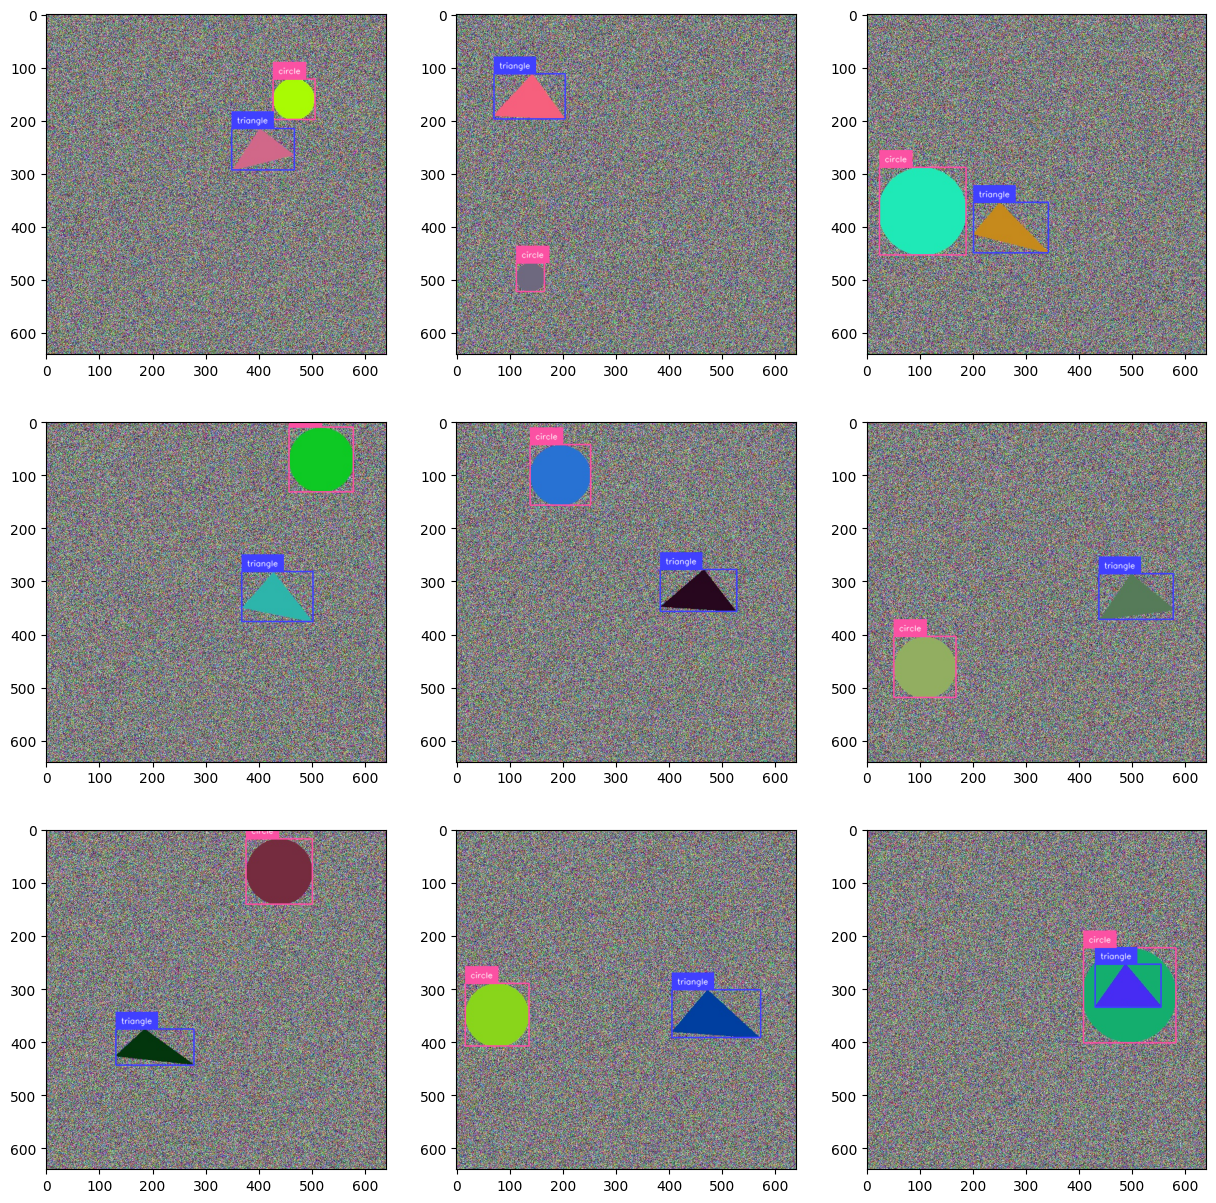

In [18]:
plt.figure(figsize=(15,15)) # specify the individual image size
#plt.figure(figsize=(15,15), dpi=1000) # specify the individual image size

for i in range(9):
    plt.subplot(3, 3, i+1)    
    plt.imshow(images[i])

plt.show()